# Potential

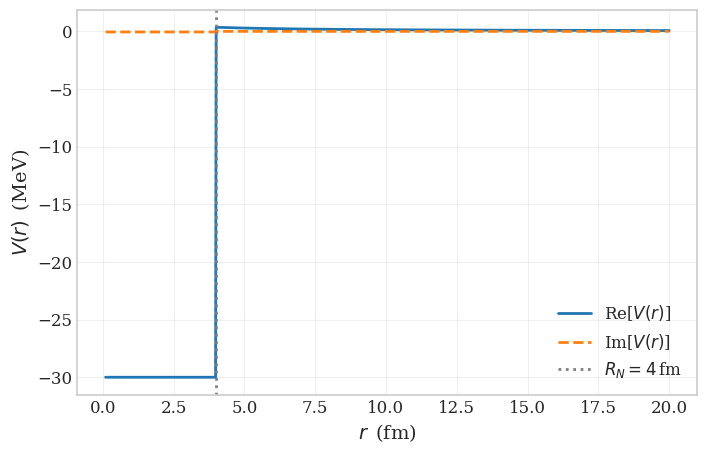

'OpticalModelImages/potencial_optico_Vr.pdf'

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros de ejemplo
Vr = -30   # MeV
Vi = -0.049  # MeV
Rn = 4  # fm
Zp = 1
Zt = 1
e2 = 1.44  # MeV·fm

# Dominio de r
r = np.linspace(0.1, 20, 1000)

# Potencial óptico
V = np.where(r < Rn, Vr + 1j*Vi, Zp*Zt*e2/r)

# Gráfica
plt.figure(figsize=(8, 5))
plt.plot(r, V.real, label='Re[$V(r)$]')
plt.plot(r, V.imag, label='Im[$V(r)$]', linestyle='--')
plt.axvline(Rn, color='gray', linestyle=':', label=f'$R_N={Rn}\\,$fm')
plt.xlabel('$r\\,$ (fm)')
plt.ylabel('$V(r)\\,$ (MeV)')
#plt.title('Potencial óptico $V(r)$')
plt.legend()
plt.grid(True)

# Guardar en PDF
pdf_path = 'OpticalModelImages/potencial_optico_Vr.pdf'
plt.savefig(pdf_path, format='pdf')

# Mostrar la gráfica
plt.show()

pdf_path


# Numerov

## Main

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import physical_constants
import mpmath as mp

"""optical_model.py – Simple 1‑partial‑wave optical‐model toy code

Changes requested 2025‑07‑08 / 09 + L calculation
---------------------------------
* Keep the ENDF/B‑VI experimental data hard‑coded.
* Accept a **path** argument to read external data files with columns::

    E_lab [MeV]  delta_real [deg]  delta_imag [deg]  cross_section [mb]  S_factor [MeV*mb]

  Units are converted internally (mb → barn).
* Accept a **L_path** argument to read L data files with columns::

    E_lab [MeV]  L_real  L_imag  |L|

* Produce **nine** figures:
    1. Re(δ0)  – model & path data
    2. Im(δ0)  – model & path data
    3. S‑factor – model & path data
    4. σ        – model & path data
    5. σ        – experimental ENDF & path data
    6. σ        – model & experimental ENDF
    7. σ        – model, experimental ENDF & path data together
    8. Re(L) and Im(L) – model & C++ data
    9. |L|     – model & C++ data
* Grid = True on every plot.
* Abscissa in **MeV** (except the L plots).
* All PDFs are stored in a folder ``OpticalModelImages`` (created if absent).
"""

mp.dps = 70  # extra precision for Coulomb functions

ħc = 197.3269804                  # MeV·fm
α = 1 / 137.035999084
_e2_4pie0 = α * ħc                # MeV·fm (e^2 / 4πϵ₀)
_m_u = physical_constants['atomic mass constant energy equivalent in MeV'][0]

# ---------------------------------------------------------------------
#  ENDF/B‑VI (p, d) sample – E_lab in MeV, σ in barn
# ---------------------------------------------------------------------
_E_lab_ENDF = np.array([
      200,   300,   400,    700,    1000,   4000,   7000,  10000,  14000,
     20000, 26000, 35000,  40000,   65000,  80000,  95000, 104000, 110000,
    120000,135000,150000, 180000,  220000, 280000], dtype=float) * 1e-6  # → MeV

_sigma_ENDF = np.array([
 7.433e-39, 4.056e-31, 1.586e-26, 2.514e-19, 1.000e-15,
 1.160e-06, 1.544e-04, 1.730e-03, 1.092e-02, 5.968e-02,
 1.691e-01, 4.700e-01, 1.370e+00, 2.656e+00, 3.957e+00,
 4.801e+00, 4.980e+00, 5.010e+00, 4.877e+00, 4.465e+00,
 3.970e+00, 3.072e+00, 2.203e+00, 1.505e+00], dtype=float)  # barn

# ---------------------------------------------------------------------
#  Low‑level helpers
# ---------------------------------------------------------------------

def _reduced_mass(Ap: float, At: float) -> float:
    """Return the reduced mass μ = m_p m_t / (m_p + m_t) in MeV/c²."""
    return Ap * _m_u * At / (Ap + At)


def _coulomb_FG(l: int, eta: float, rho: float):
    """Coulomb F, G and their radial derivatives using *mpmath*."""
    F = mp.coulombf(l, eta, rho)
    G = mp.coulombg(l, eta, rho)
    Fp = mp.diff(lambda x: mp.coulombf(l, eta, x), rho)
    Gp = mp.diff(lambda x: mp.coulombg(l, eta, x), rho)
    return complex(F), complex(G), complex(Fp), complex(Gp)


def _delta0(E: float, Zp: int, Zt: int, Ap: float, At: float,
            Vr: float, Vi: float, r0: float):
    """s‑wave complex phase shift δ₀(E)."""
    μ = _reduced_mass(Ap, At)
    k = np.sqrt(2 * μ * E) / ħc
    a_c = ħc ** 2 / (μ * _e2_4pie0 * Zp * Zt)
    eta = 1.0 / (k * a_c)
    R_N = r0 * (At ** (1 / 3) + Ap ** (1 / 3))
    k_N = np.sqrt(2 * μ * (E - Vr - 1j * Vi)) / ħc
    rho = k * R_N

    F, G, Fp, Gp = _coulomb_FG(0, eta, rho)
    cot_kNR = np.cos(k_N * R_N) / np.sin(k_N * R_N)
    W = (k_N * cot_kNR * G - k * Gp) / (k * Fp - k_N * cot_kNR * F)
    delta = np.arctan(1 / W)
    return delta, W, k, ħc


def _sigma_S(E: float, k: float, W: complex, μ: float,
             Zp: int, Zt: int):
    """Return (σ, S) in barn and MeV·barn, respectively."""
    W_r, W_i = W.real, W.imag
    delta = np.arctan(1/W)
    sigma = (np.pi / k ** 2) * (-4 * W_i) / (W_r ** 2 + (W_i - 1) ** 2) /100  # barn /100 --> fm**2 to barn
    B_G = Zp * Zt * _e2_4pie0 * np.sqrt(2 * μ) / ħc                     # MeV¹ᐟ²·fm

    # Use *mpmath* to keep exp() under control
    E_mpf = mp.mpf(E)
    try:
        S_mpf = mp.mpf(sigma) * E_mpf * mp.exp(B_G / mp.sqrt(E_mpf))
        S = float(S_mpf) if mp.log(S_mpf) < 700 else np.nan  # cap at ~1e304
    except (OverflowError, ValueError):
        S = np.nan
    return sigma, S


def _L_function(E: float, a: float, p):
    """Calculate L = a * du(a) / u(a) at channel radius a."""
    Zp, Zt, Ap, At, Vr, Vi, r0 = p
    μ = _reduced_mass(Ap, At)
    k = np.sqrt(2 * μ * E) / ħc
    R_N = r0 * (At ** (1 / 3) + Ap ** (1 / 3))
    delta, _, k_val, a_c = _delta0(E, *p[:4], Vr, Vi, r0)
    k_N = np.sqrt(2 * μ * (E - Vr - 1j * Vi)) / ħc

    # Calculate wavefunction and derivative at r = a
    #if a < R_N:
        # Interior region
    u_a = np.sin(k_N * a)
    du_a = k_N * np.cos(k_N * a)
    #else:
        # Exterior region
      #  B = 1.0  # normalization constant
      #  F0, G0, Fp0, Gp0 = _coulomb_FG(0, 1 / (k_val * a_c), k_val * R_N)
      #  cot_delta = 1 / np.tan(delta)
       # D = B * np.sin(k_N * R_N) / (F0 * cot_delta + G0)
        
        # Coulomb functions at r = a
       # F_a, G_a, Fp_a, Gp_a = _coulomb_FG(0, 1 / (k_val * a_c), k_val * a)
        
       #u_a = D * (F_a * cot_delta + G_a)
        #du_a = D * (Fp_a * cot_delta + Gp_a) * k_val

    # Calculate L = a * du(a) / u(a)
    L = a * du_a / u_a
    return L

# ---------------------------------------------------------------------
#  User‑level driver
# ---------------------------------------------------------------------

def run_optical_model(Zp: int, Zt: int, Ap: float, At: float,
                      Vr: float, Vi: float, r0: float,
                      E_range_eV=(120.0, 168000.0), n_E=600,
                      a_channel: float = 1.0,  # channel radius in fm
                      path: str | None = None,
                      L_path: str | None = None,
                      show: bool = True, save: bool = True,
                      return_data: bool = False):
    """Compute phase‑shift, σ, S‑factor and L curves and create comparison plot.

    Parameters
    ----------
    Zp, Zt, Ap, At, Vr, Vi, r0 : optical‑model parameters.
    E_range_eV  : *(min, max)* CM energy (eV).
    n_E         : number of energy points (log‑spaced).
    a_channel   : channel radius in fm for L calculation.
    path        : external ``.dat`` file with five columns.
    L_path      : external ``.dat`` file with L data (four columns).
    show        : call ``plt.show()`` at the end of the run.
    save        : write PDFs inside *OpticalModelImages/*.
    return_data : return a dict with raw arrays.
    """
    # ░░░ preparation ░░░
    E_min, E_max = (x * 1e-6 for x in E_range_eV)          # → MeV
    E_cm = np.geomspace(E_min, E_max, n_E)                 # log spacing
    E_lab = (Ap + At) / At * E_cm                          # simple conversion

    params = (Zp, Zt, Ap, At, Vr, Vi, r0)
    μ = _reduced_mass(Ap, At)

    # ░░░ theoretical curves ░░░
    delta = []
    sigma = []
    S_factor = []
    L_values = []
    
    for E in E_cm:
        dE, W, kE, μ = _delta0(E, *params)
        sigma_E, S_E = _sigma_S(E, kE, W, μ, Zp, Zt)
        L_E = _L_function(E, a_channel, params)
        
        delta.append(dE)
        sigma.append(sigma_E)
        S_factor.append(S_E)
        L_values.append(L_E)

    delta = np.array(delta)
    sigma = np.array(sigma)
    S_factor = np.array(S_factor)
    L_values = np.array(L_values)

    # ░░░ external path data ░░░
    if path and os.path.exists(path):
        dat = np.loadtxt(path, comments=['#', '%'])
        E_dat = dat[:, 0]  # MeV already
        d_re_dat = dat[:, 1]
        d_im_dat = dat[:, 2]
        sigma_dat = dat[:, 3]          # mb → barn
        S_dat = dat[:, 4]              # MeV·mb → MeV·barn
    else:
        E_dat = d_re_dat = d_im_dat = sigma_dat = S_dat = None

    # ░░░ external L data ░░░
    if L_path and os.path.exists(L_path):
        L_dat = np.loadtxt(L_path, comments=['#', '%'])
        E_L_dat = L_dat[:, 0]  # MeV already
        L_re_dat = L_dat[:, 1]
        L_im_dat = L_dat[:, 2]
        L_mag_dat = L_dat[:, 3]
    else:
        E_L_dat = L_re_dat = L_im_dat = L_mag_dat = None

    # ░░░ output directory ░░░
    out_dir = 'OpticalModelImages'
    if save:
        os.makedirs(out_dir, exist_ok=True)

    # ░░░ Configuración de estilo profesional ░░░
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'serif',
        'axes.linewidth': 1.2,
        'axes.labelsize': 14,
        'axes.titlesize': 16,
        'xtick.labelsize': 12,
        'ytick.labelsize': 12,
        'legend.fontsize': 12,
        'grid.alpha': 0.3,
        'lines.linewidth': 2,
        'figure.facecolor': 'white',
        'axes.facecolor': 'white'
    })

    # ░░░ Crear la gráfica estética principal ░░░
    fig, ax = plt.subplots(figsize=(12, 8))

    # Colores profesionales
    colors = {
        'modelo': '#2E86C1',      # Azul elegante
        'endf': '#E74C3C',        # Rojo elegante
        'numerov': '#27AE60'      # Verde elegante
    }

    # Gráfica principal - Comparación de los tres resultados
    ax.plot(E_lab, sigma, color=colors['modelo'], linewidth=2.5, 
            label='Modelo Analítico', zorder=3)
    ax.scatter(_E_lab_ENDF, _sigma_ENDF, color=colors['endf'], 
               s=40, alpha=0.8, label='Datos ENDF', zorder=2, marker='o')
    if E_dat is not None:
        ax.plot(E_dat, sigma_dat, color=colors['numerov'], linewidth=2, 
                linestyle='--', label='Numerov', zorder=1, alpha=0.9)

    # Configuración de la gráfica principal
    ax.set_xlabel('$E_{lab}$ (MeV)', fontsize=16, fontweight='bold')
    ax.set_ylabel('$\\sigma$ (barn)', fontsize=16, fontweight='bold')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    # Título principal
    ax.set_title('Comparación de Sección Eficaz: Modelo Analítico vs Datos ENDF vs Numerov', 
                 fontsize=18, fontweight='bold', pad=20)

    # Leyenda principal con marco elegante
    legend = ax.legend(loc='upper right', frameon=True, fancybox=True, 
                      shadow=True, borderpad=1, fontsize=13)
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.95)
    legend.get_frame().set_edgecolor('gray')

    # ░░░ Crear la gráfica de zoom en la esquina inferior ░░░
    zoom_ax = fig.add_axes([0.15, 0.15, 0.35, 0.25])

    # Filtrar datos para el rango del zoom (10^-3 hasta 10^1)
    mask_main = (sigma >= 1e-3) & (sigma <= 10)
    mask_endf = (_sigma_ENDF >= 1e-3) & (_sigma_ENDF <= 10)
    if E_dat is not None:
        mask_numerov = (sigma_dat >= 1e-3) & (sigma_dat <= 10)

    # Encontrar el rango de energías correspondiente para el zoom
    if np.any(mask_main):
        E_zoom_min = E_lab[mask_main].min()
        E_zoom_max = E_lab[mask_main].max()
    else:
        E_zoom_min = E_lab.min()
        E_zoom_max = E_lab.max()

    # Gráfica de zoom
    zoom_ax.plot(E_lab, sigma, color=colors['modelo'], linewidth=2)
    zoom_ax.scatter(_E_lab_ENDF, _sigma_ENDF, color=colors['endf'], 
                    s=20, alpha=0.8, marker='o')
    if E_dat is not None:
        zoom_ax.plot(E_dat, sigma_dat, color=colors['numerov'], linewidth=1.5, 
                     linestyle='--', alpha=0.9)

    # Configuración del zoom
    zoom_ax.set_yscale('log')
    zoom_ax.set_ylim(1e-3, 10)
    zoom_ax.set_xlim(E_zoom_min, E_zoom_max)
    zoom_ax.grid(True, alpha=0.4, linestyle=':', linewidth=0.5)
    zoom_ax.set_xlabel('$E_{lab}$ (MeV)', fontsize=10)
    zoom_ax.set_ylabel('$\\sigma$ (barn)', fontsize=10)
    zoom_ax.tick_params(labelsize=9)

    # Título del zoom
    zoom_ax.set_title('Zoom: $10^{-3}$ - $10^{1}$ barn', fontsize=11, 
                      fontweight='bold', pad=5)

    # Marco elegante para el zoom
    for spine in zoom_ax.spines.values():
        spine.set_linewidth(2)
        spine.set_color('black')

    # Rectángulo de conexión en la gráfica principal
    from matplotlib.patches import Rectangle
    zoom_region = Rectangle((E_zoom_min, 1e-3), E_zoom_max - E_zoom_min, 
                           10 - 1e-3, fill=False, edgecolor='red', 
                           linewidth=1.5, linestyle=':', alpha=0.7)
    ax.add_patch(zoom_region)

    # Ajustar diseño
    plt.tight_layout()

    # Guardar y mostrar
    if save:
        filename = os.path.join(out_dir, 'comparacion_seccion_eficaz_completa.pdf')
        fig.savefig(filename, dpi=300, bbox_inches='tight', 
                   facecolor='white', edgecolor='none')
        print(f"Gráfica guardada en: {filename}")

    if show:
        plt.show()

    # Información en consola
    print("\n" + "="*60)
    print("GRÁFICA DE COMPARACIÓN GENERADA")
    print("="*60)
    print(f"• Modelo Analítico: Línea sólida azul")
    print(f"• Datos ENDF: Puntos rojos")
    if E_dat is not None:
        print(f"• Numerov: Línea discontinua verde")
    else:
        print(f"• Numerov: No disponible (sin datos)")
    print(f"• Zoom: Sección eficaz entre 10⁻³ y 10¹ barn")
    print(f"• Rango de energía: {E_lab.min():.3f} - {E_lab.max():.3f} MeV")
    print(f"• Número de puntos: {len(E_lab)}")
    print("="*60)

    if return_data:
        out = {
            'E_cm_MeV': E_cm,
            'E_lab_MeV': E_lab,
            'delta': delta,
            'sigma_barn': sigma,
            'S_MeVbarn': S_factor,
            'L_complex': L_values,
            'E_lab_ENDF_MeV': _E_lab_ENDF,
            'sigma_ENDF_barn': _sigma_ENDF,
        }
        if E_dat is not None:
            out.update({
                'E_lab_path_MeV': E_dat,
                'delta_re_path_deg': d_re_dat,
                'delta_im_path_deg': d_im_dat,
                'sigma_path_barn': sigma_dat,
                'S_path_MeVbarn': S_dat,
            })
        if E_L_dat is not None:
            out.update({
                'E_lab_L_path_MeV': E_L_dat,
                'L_re_path': L_re_dat,
                'L_im_path': L_im_dat,
                'L_mag_path': L_mag_dat,
            })
        return out


/tmp/ipykernel_10380/2362113666.py:328: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Gráfica guardada en: OpticalModelImages/comparacion_seccion_eficaz_completa.pdf


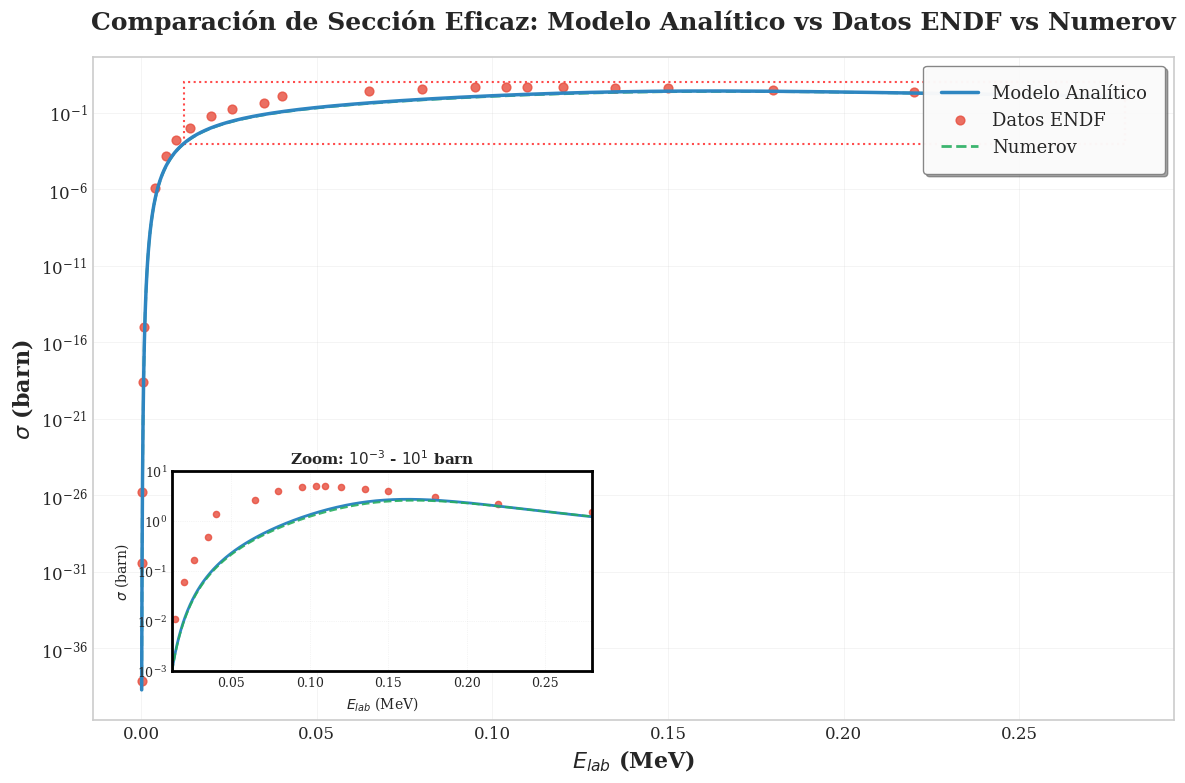


GRÁFICA DE COMPARACIÓN GENERADA
• Modelo Analítico: Línea sólida azul
• Datos ENDF: Puntos rojos
• Numerov: Línea discontinua verde
• Zoom: Sección eficaz entre 10⁻³ y 10¹ barn
• Rango de energía: 0.000 - 0.280 MeV
• Número de puntos: 600


In [28]:
run_optical_model(
    Zp=1, Zt=1,        # deuterón + algo
    Ap=2, At=3,        # masas (amu)
    Vr=-30, Vi=-0.04964,   # potencial MeV
    r0=1.338,            # fm
     path='../c++/OpticModel/data/datfiles_l=0_a=4/WrWi_vs_Elab.dat',
     L_path ='../c++/OpticModel/data/datfiles_l=0_a=4/L_vs_Elab.dat',
)

/tmp/ipykernel_10380/2362113666.py:328: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


Gráfica guardada en: OpticalModelImages/comparacion_seccion_eficaz_completa.pdf


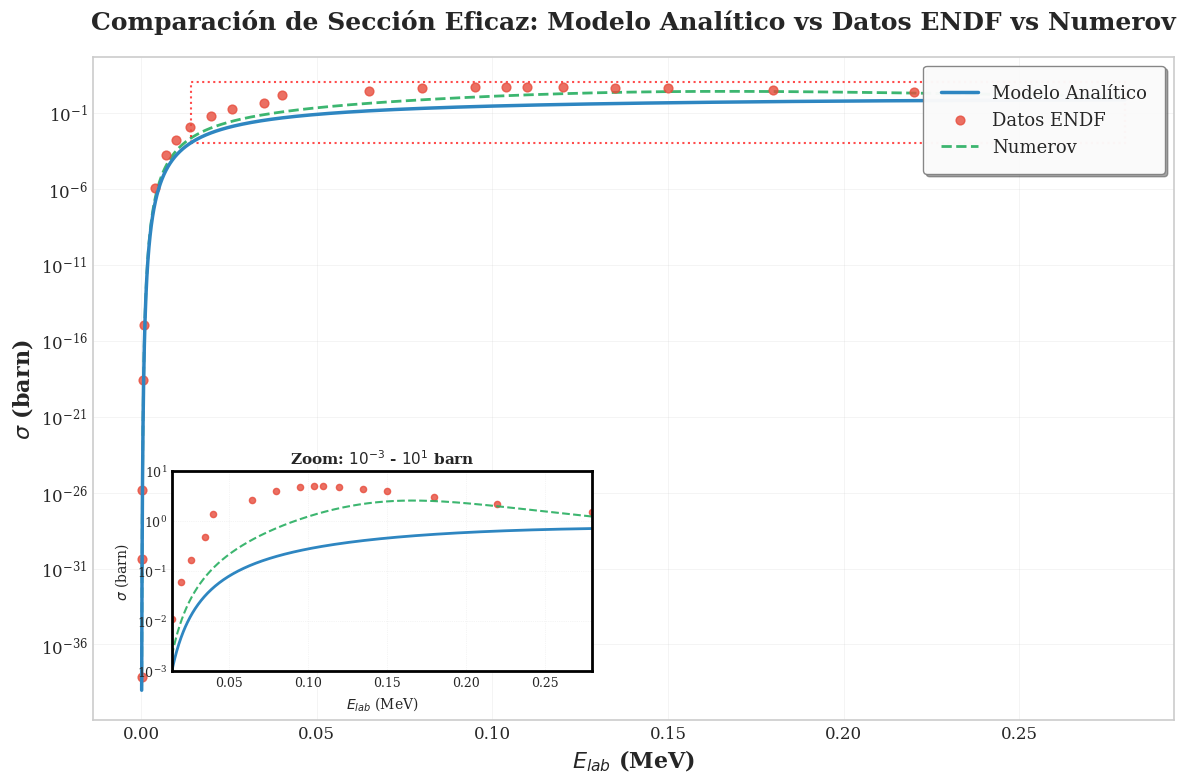


GRÁFICA DE COMPARACIÓN GENERADA
• Modelo Analítico: Línea sólida azul
• Datos ENDF: Puntos rojos
• Numerov: Línea discontinua verde
• Zoom: Sección eficaz entre 10⁻³ y 10¹ barn
• Rango de energía: 0.000 - 0.280 MeV
• Número de puntos: 600


In [29]:
run_optical_model(
    Zp=1, Zt=1,        # deuterón + algo
    Ap=2, At=3,        # masas (amu)
    Vr=-47.667, Vi=-0.117292,  # potencial MeV
    r0=1.746,            # fm
     path='../c++/OpticModel/data/datfiles_l=0_a=4/WrWi_vs_Elab.dat',
     L_path ='../c++/OpticModel/data/datfiles_l=0_a=4/L_vs_Elab.dat',
)

# Pruebas

Radio nuclear R_N = 3.616 fm
Potencial nuclear: V_r = -30.0 MeV, V_i = -0.04964 MeV
Masa reducida μ = 1117.793 MeV/c²

Comparación L vs k_N * cot(k_N * R_N):
E (MeV)    L (real)        L (imag)        kN*cot (real)   kN*cot (imag)  
------------------------------------------------------------
-25.00     -0.739091       -0.025042       -0.743110       -0.025058      
-22.96     -2.043651       -0.040609       -2.048391       -0.040643      
-20.92     -4.438775       -0.084697       -4.445898       -0.084813      
-18.88     -11.173565      -0.322509       -11.195588      -0.323528      
-16.84     95.079543       -512.994854     128.939020      -497.175920    
-14.80     14.047339       -0.317771       14.014894       -0.316541      
-12.76     7.347179        -0.085667       7.334446        -0.085502      
-10.71     4.881334        -0.042960       4.872584        -0.042913      
-8.67      3.457562        -0.028483       3.450250        -0.028466      
-6.63      2.430147        -0.0

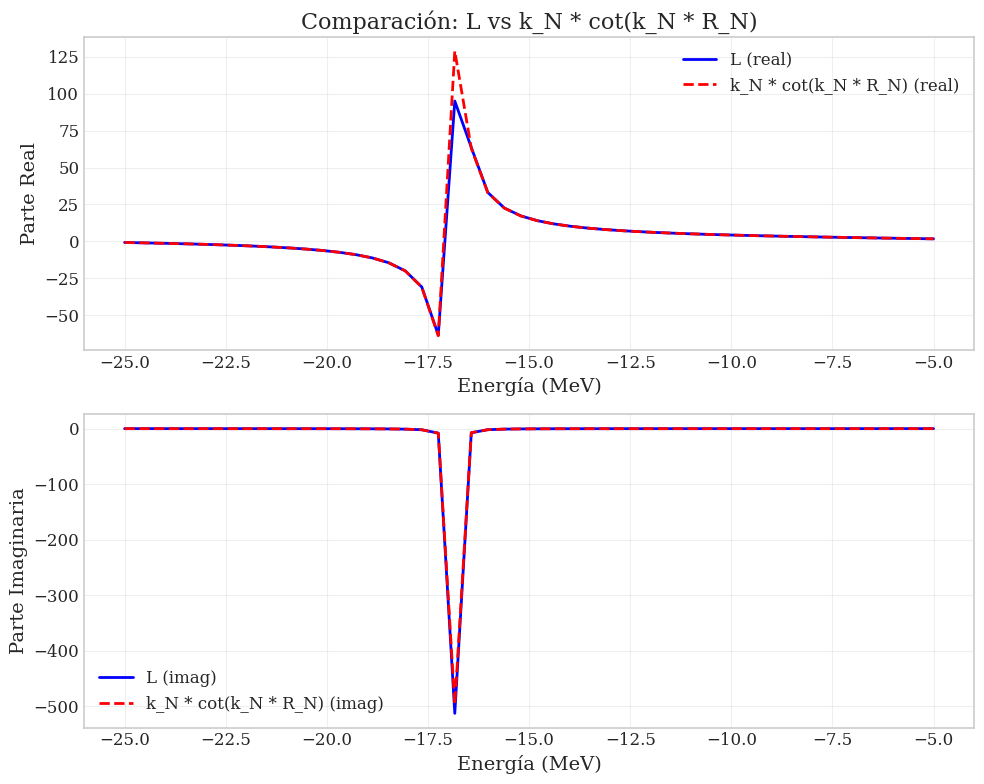


Mínima diferencia en E = -25.000 MeV
L = -0.739091-0.025042j
k_N * cot = -0.743110-0.025058j
Diferencia total = 0.004018


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constantes físicas
Z_P = 1  # Deuterio
Z_T = 1  # Tritio
A_P = 2  # Masa del proyectil
A_T = 3  # Masa del blanco

uma_to_MeV = 931.494
hbar = 197.326980  # MeV·fm
e2 = 1.44  # e² en MeV·fm
alpha = 0.0072973525693

# Masa reducida
mu = (A_P * A_T * uma_to_MeV) / (A_P + A_T)  # MeV/c²

# Parámetros del potencial nuclear (tipo 2)
V_r = -30.0  # MeV (parte real)
V_i = -0.04964  # MeV (parte imaginaria)
a_p = 1.338  # fm
R_N = a_p * (A_P**(1/3) + A_T**(1/3))  # Radio nuclear

def f_complex(r, l, E):
    """Función f para el método de Numerov (compleja)"""
    if r < R_N:
        V_eff = complex(V_r, V_i)  # Potencial nuclear complejo
    else:
        V_eff = (Z_P * Z_T * e2) / r  # Potencial Coulomb
    
    return -(2.0 * mu / (hbar**2)) * (V_eff - E)

def numerov_complex(l, E, a, h=0.001):
    """Método de Numerov para números complejos"""
    # Crear array r
    r = np.arange(h, a + 2*h + 1e-12, h)
    n = len(r)
    
    u = np.zeros(n, dtype=complex)
    
    # Condiciones iniciales
    u[0] = 0.0 + 0.0j
    u[1] = h + 0.0j
    
    # Algoritmo de Numerov
    for i in range(2, n):
        f_i = f_complex(r[i], l, E)
        f_im1 = f_complex(r[i-1], l, E)
        f_im2 = f_complex(r[i-2], l, E)
        
        denom = 1.0 + (h**2 / 12.0) * f_i
        num = (2.0 * u[i-1] * (1.0 - (5.0 * h**2 / 12.0) * f_im1) - 
               u[i-2] * (1.0 + (h**2 / 12.0) * f_im2))
        u[i] = num / denom
    
    # Calcular derivadas
    du = np.zeros(n-1, dtype=complex)
    for i in range(n-1):
        if i == 0:
            # Forward difference
            du[i] = (u[i+1] - u[i]) / h
        elif i == n-2:
            # Backward difference
            du[i] = (u[i] - u[i-1]) / h
        else:
            # Central difference
            du[i] = (u[i+1] - u[i-1]) / (2.0 * h)
    
    return r, u, du

def calculate_L(r, u, du, a):
    """Calcular la derivada logarítmica L en r = a"""
    # Encontrar el índice más cercano a 'a'
    index = np.argmin(np.abs(r - a))
    
    # Ajustar si es necesario para evitar índices fuera de rango
    if index >= len(du):
        index = len(du) - 1
    
    # Calcular L
    L = a * du[index] / u[index] if index < len(u) - 1 else a * du[index] / u[index]
    
    return L

def calculate_kN_cot_kNR(E):
    """Calcular k_N * cot(k_N * R_N)"""
    # k_N en el interior del núcleo
    k_N = np.sqrt(2 * mu * (E - V_r - 1j * V_i)) / hbar
    
    # cot(k_N * R_N)
    cot_kNR = R_N*np.cos(k_N * R_N) / np.sin(k_N * R_N)
    
    return k_N * cot_kNR

def compare_L_and_kN_cot(E_values, l=0, a=None):
    """Comparar L con k_N * cot(k_N * R_N) para diferentes energías"""
    if a is None:
        a = R_N  # Evaluar en el radio nuclear
    
    L_values = []
    kN_cot_values = []
    
    for E in E_values:
        # Calcular L usando Numerov
        r, u, du = numerov_complex(l, E, a + 5.0)  # Extender un poco más allá de 'a'
        L = calculate_L(r, u, du, a)
        L_values.append(L)
        
        # Calcular k_N * cot(k_N * R_N)
        kN_cot = calculate_kN_cot_kNR(E)
        kN_cot_values.append(kN_cot)
    
    return np.array(L_values), np.array(kN_cot_values)

# Ejemplo de uso
if __name__ == "__main__":
    # Rango de energías para probar
    E_values = np.linspace(-25.0, -5.0, 50)  # MeV
    
    print(f"Radio nuclear R_N = {R_N:.3f} fm")
    print(f"Potencial nuclear: V_r = {V_r} MeV, V_i = {V_i} MeV")
    print(f"Masa reducida μ = {mu:.3f} MeV/c²")
    
    # Comparar en el radio nuclear
    L_values, kN_cot_values = compare_L_and_kN_cot(E_values, l=0, a=R_N)
    
    # Mostrar algunos resultados
    print("\nComparación L vs k_N * cot(k_N * R_N):")
    print("=" * 60)
    print(f"{'E (MeV)':<10} {'L (real)':<15} {'L (imag)':<15} {'kN*cot (real)':<15} {'kN*cot (imag)':<15}")
    print("-" * 60)
    
    for i in range(0, len(E_values), 5):  # Mostrar cada 5 valores
        E = E_values[i]
        L = L_values[i]
        kN_cot = kN_cot_values[i]
        print(f"{E:<10.2f} {L.real:<15.6f} {L.imag:<15.6f} {kN_cot.real:<15.6f} {kN_cot.imag:<15.6f}")
    
    # Graficar comparación
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))
    
    # Parte real
    ax1.plot(E_values, L_values.real, 'b-', label='L (real)', linewidth=2)
    ax1.plot(E_values, kN_cot_values.real, 'r--', label='k_N * cot(k_N * R_N) (real)', linewidth=2)
    ax1.set_xlabel('Energía (MeV)')
    ax1.set_ylabel('Parte Real')
    ax1.set_title('Comparación: L vs k_N * cot(k_N * R_N)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Parte imaginaria
    ax2.plot(E_values, L_values.imag, 'b-', label='L (imag)', linewidth=2)
    ax2.plot(E_values, kN_cot_values.imag, 'r--', label='k_N * cot(k_N * R_N) (imag)', linewidth=2)
    ax2.set_xlabel('Energía (MeV)')
    ax2.set_ylabel('Parte Imaginaria')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Encontrar intersecciones (donde L ≈ k_N * cot)
    diff_real = np.abs(L_values.real - kN_cot_values.real)
    diff_imag = np.abs(L_values.imag - kN_cot_values.imag)
    diff_total = np.sqrt(diff_real**2 + diff_imag**2)
    
    min_index = np.argmin(diff_total)
    print(f"\nMínima diferencia en E = {E_values[min_index]:.3f} MeV")
    print(f"L = {L_values[min_index]:.6f}")
    print(f"k_N * cot = {kN_cot_values[min_index]:.6f}")
    print(f"Diferencia total = {diff_total[min_index]:.6f}")

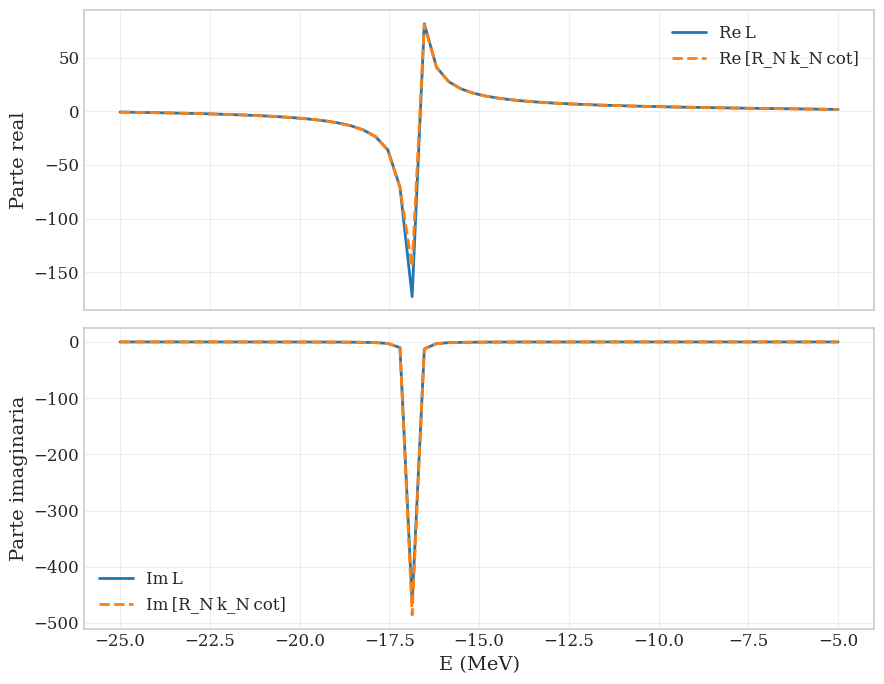


Mejor coincidencia en E = -25.00 MeV  |L−R_Nk_Ncot| = 4.018e-03


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
# Constantes físicas y parámetros del potencial
# ---------------------------------------------------------------
Z_P, Z_T = 1, 1
A_P, A_T = 2, 3
uma_to_MeV = 931.494
ħ = 197.326980          # MeV·fm
e2 = 1.44               # MeV·fm (αħc)

μ  = (A_P*A_T*uma_to_MeV) / (A_P + A_T)     # MeV
V_r, V_i = -30.0, -0.04964                  # MeV
a_p = 1.338                                  # fm
R_N = a_p*(A_P**(1/3) + A_T**(1/3))          # fm

# ---------------------------------------------------------------
# Factor f(r) para Numerov   u'' = f(r) u
# (signo correcto:   f ∝ E − V )
# ---------------------------------------------------------------
def f_complex(r, l, E):
    V = (Z_P*Z_T*e2)/r if r >= R_N else complex(V_r, V_i)
    centrifugal = l*(l+1)/r**2 if r > 0 else 0.0
    return centrifugal + (2.0*μ/ħ**2)*(E - V)

# ---------------------------------------------------------------
# Integrador Numerov complejo
# ---------------------------------------------------------------
def numerov(l, E, r_match, h=1e-3):
    r = np.arange(h, r_match + 10*h, h)
    u = np.zeros_like(r, dtype=np.complex128)

    # Condición regular (l=0 ⇒ u ∝ r)
    u[0] = 0.0
    u[1] = h**(l+1)

    for i in range(2, len(r)):
        f_i, f_im1, f_im2 = f_complex(r[i], l, E), \
                            f_complex(r[i-1], l, E), \
                            f_complex(r[i-2], l, E)
        denom = 1.0 + h**2*f_i/12.0
        num   = (2.0*u[i-1]*(1.0 - 5.0*h**2*f_im1/12.0)
                 - u[i-2]*(1.0 + h**2*f_im2/12.0))
        u[i]  = num/denom

    du = np.empty_like(u)
    du[0], du[-1] = (u[1]-u[0])/h, (u[-1]-u[-2])/h
    du[1:-1] = (u[2:] - u[:-2])/(2*h)
    return r, u, du

def L_of_E(E, l=0, a=R_N, h=1e-3):
    r, u, du = numerov(l, E, a, h)
    idx = np.argmin(np.abs(r - a))
    return a*du[idx]/u[idx]

# ---------------------------------------------------------------
# Expresión analítica   R_N·k_N·cot(k_NR_N)
# ¡OJO al R_N!
# ---------------------------------------------------------------
def kN_cot(E):
    kN = np.sqrt(2.0*μ*(E - V_r - 1j*V_i))/ħ
    return R_N * kN * np.cos(kN*R_N)/np.sin(kN*R_N)

# ---------------------------------------------------------------
# Comparación numérica
# ---------------------------------------------------------------
if __name__ == "__main__":
    E_grid = np.linspace(-25.0, -5.0, 60)        # MeV

    L_vals  = np.array([L_of_E(E) for E in E_grid])
    KC_vals = np.array([kN_cot(E)  for E in E_grid])

    # ---------- Gráfica ----------
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 7), sharex=True)
    ax1.plot(E_grid, L_vals.real,  label='Re L', lw=2)
    ax1.plot(E_grid, KC_vals.real, '--', label='Re [R_N k_N cot]', lw=2)
    ax1.set_ylabel('Parte real');  ax1.grid(alpha=.3); ax1.legend()

    ax2.plot(E_grid, L_vals.imag,  label='Im L', lw=2)
    ax2.plot(E_grid, KC_vals.imag, '--', label='Im [R_N k_N cot]', lw=2)
    ax2.set_xlabel('E (MeV)');     ax2.set_ylabel('Parte imaginaria')
    ax2.grid(alpha=.3); ax2.legend()
    plt.tight_layout(); plt.show()

    # ---------- Diagnóstico rápido ----------
    diff = np.abs(L_vals - KC_vals)
    idx  = diff.argmin()
    print(f"\nMejor coincidencia en E = {E_grid[idx]:.2f} MeV  |L−R_Nk_Ncot| = {diff[idx]:.3e}")


Calculando valores para comparación...


/root/venv/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/root/venv/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


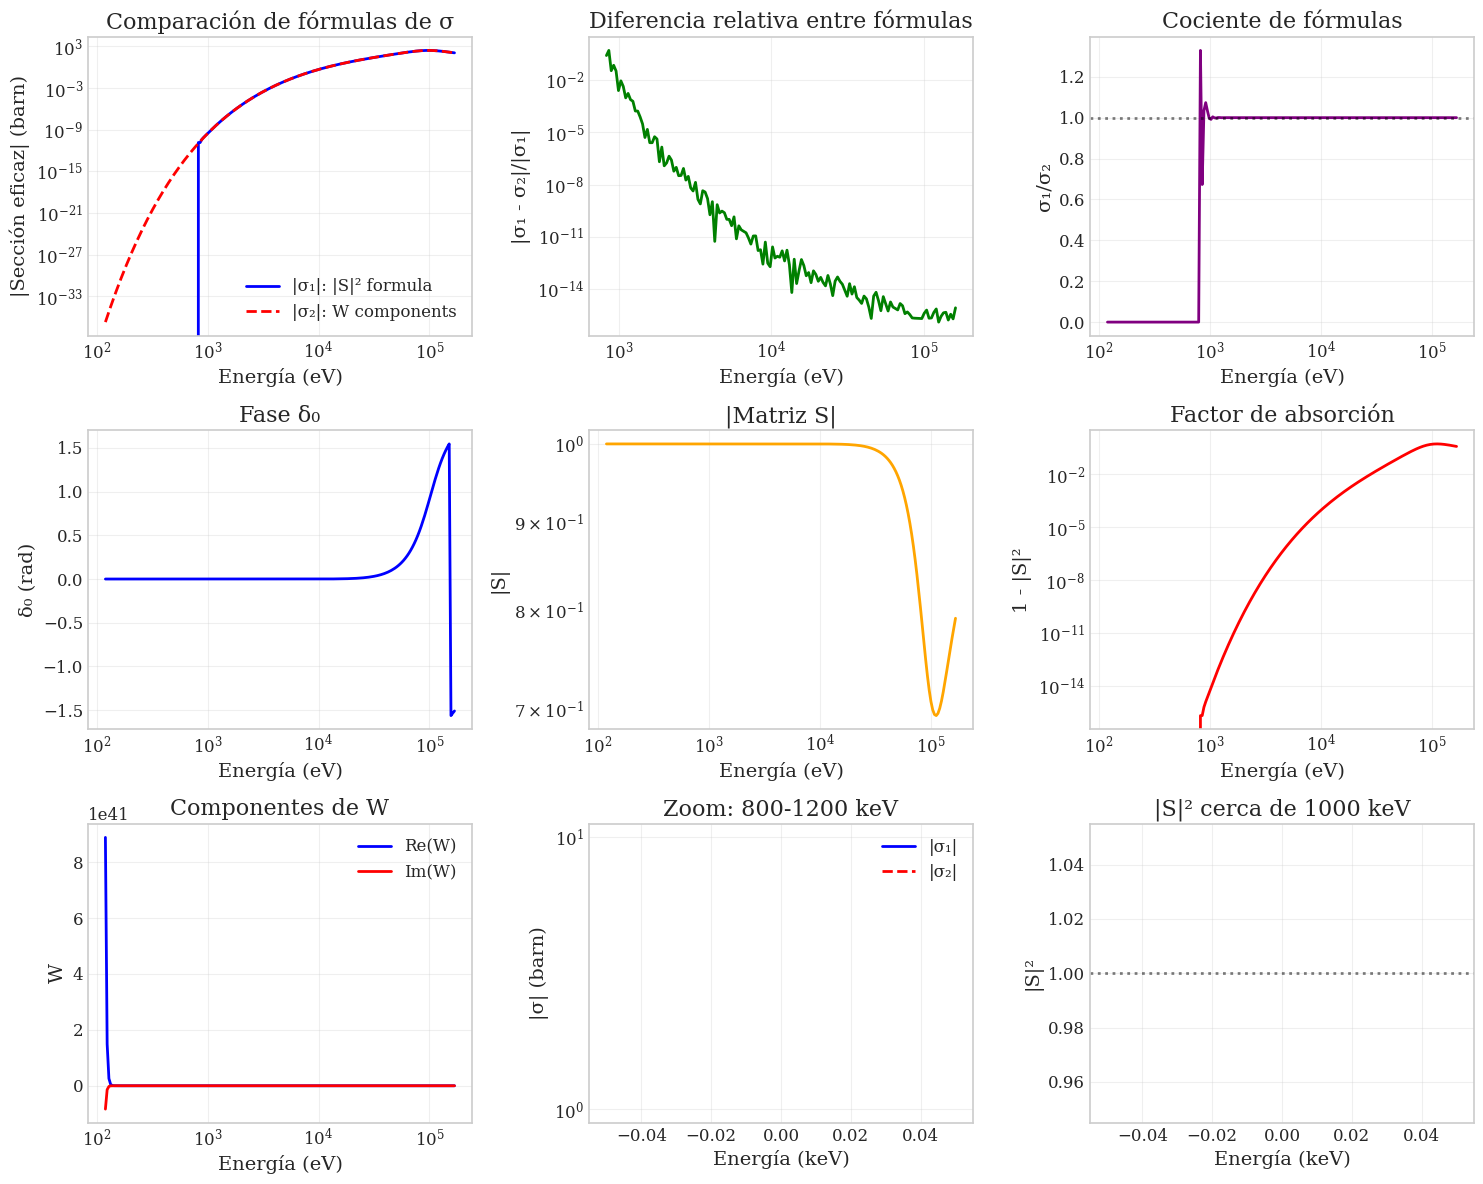


Estadísticas de diferencia relativa:
Puntos válidos para comparación: 147/200
Promedio: 6.037417e-03
Mediana: 5.030271e-13
Máximo: 4.862047e-01
Mínimo: 0.000000e+00
Máxima diferencia en E = 8.568e+02 eV

Valores en el punto de máxima diferencia:
σ₁ = 1.417971e-11 barn
σ₂ = 2.107395e-11 barn

Energías con σ₁ ≈ 0: 53 puntos
Energías con σ₁ = 0: 53 puntos
Rango de energías con σ₁ ≈ 0: 1.200e+02 - 7.967e+02 eV

Gráfico guardado en: OpticalModelImages/sigma_comparison.pdf


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import physical_constants
import mpmath as mp

# Configuración de precisión
mp.dps = 70

# Constantes físicas
ħc = 197.3269804                  # MeV·fm
α = 1 / 137.035999084
_e2_4pie0 = α * ħc                # MeV·fm (e^2 / 4πϵ₀)
_m_u = physical_constants['atomic mass constant energy equivalent in MeV'][0]

def _reduced_mass(Ap: float, At: float) -> float:
    """Return the reduced mass μ = m_p m_t / (m_p + m_t) in MeV/c²."""
    return Ap * _m_u * At / (Ap + At)

def _coulomb_FG(l: int, eta: float, rho: float):
    """Coulomb F, G and their radial derivatives using *mpmath*."""
    F = mp.coulombf(l, eta, rho)
    G = mp.coulombg(l, eta, rho)
    Fp = mp.diff(lambda x: mp.coulombf(l, eta, x), rho)
    Gp = mp.diff(lambda x: mp.coulombg(l, eta, x), rho)
    return complex(F), complex(G), complex(Fp), complex(Gp)

def _delta0(E: float, Zp: int, Zt: int, Ap: float, At: float,
            Vr: float, Vi: float, r0: float):
    """s‑wave complex phase shift δ₀(E)."""
    μ = _reduced_mass(Ap, At)
    k = np.sqrt(2 * μ * E) / ħc
    a_c = ħc ** 2 / (μ * _e2_4pie0 * Zp * Zt)
    eta = 1.0 / (k * a_c)
    R_N = r0 * (At ** (1 / 3) + Ap ** (1 / 3))
    k_N = np.sqrt(2 * μ * (E - Vr - 1j * Vi)) / ħc
    rho = k * R_N

    F, G, Fp, Gp = _coulomb_FG(0, eta, rho)
    cot_kNR = np.cos(k_N * R_N) / np.sin(k_N * R_N)
    W = (k_N * cot_kNR * G - k * Gp) / (k * Fp - k_N * cot_kNR * F)
    delta = np.arctan(1 / W)
    return delta, W, k, a_c

def _sigma_both_formulas(E: float, k: float, W: complex, μ: float,
                        Zp: int, Zt: int):
    """Return (σ₁, σ₂, S) usando ambas fórmulas para sigma."""
    W_r, W_i = W.real, W.imag
    delta = np.arctan(1/W)
    
    # Fórmula 1: usando matriz S
    sigma1 = (np.pi/k**2) * (1 - (np.abs(np.exp(2j*delta)))**2)
    
    # Fórmula 2: usando componentes de W directamente
    sigma2 = np.pi / k ** 2 * (-4 * W_i) / (W_r ** 2 + (W_i - 1) ** 2)
    
    # Factor S usando sigma1
    B_G = Zp * Zt * _e2_4pie0 * np.sqrt(2 * μ) / ħc
    E_mpf = mp.mpf(E)
    try:
        S_mpf = mp.mpf(sigma1) * E_mpf * mp.e ** (B_G / mp.sqrt(E_mpf))
        S = float(S_mpf) if mp.log(S_mpf) < 700 else np.nan
    except (OverflowError, ValueError):
        S = np.nan
    
    return sigma1, sigma2, S

# Parámetros del problema
E_range_eV = (120.0, 168000.0)
Zp, Zt = 1, 1        # deuterón + algo
Ap, At = 2, 3        # masas (amu)
Vr, Vi = -30, -0.04964   # potencial MeV
r0 = 1.338

# Convertir energías a MeV
E_min = E_range_eV[0] * 1e-6  # eV to MeV
E_max = E_range_eV[1] * 1e-6  # eV to MeV

# Crear grid de energías (escala logarítmica)
E_array = np.logspace(np.log10(E_min), np.log10(E_max), 200)

# Arrays para almacenar resultados
sigma1_array = []
sigma2_array = []
S_array = []
# Arrays para diagnóstico
delta_array = []
W_real_array = []
W_imag_array = []
k_array = []
S_matrix_abs_array = []

print("Calculando valores para comparación...")
μ = _reduced_mass(Ap, At)

for i, E in enumerate(E_array):
    try:
        delta, W, k, a_c = _delta0(E, Zp, Zt, Ap, At, Vr, Vi, r0)
        sigma1, sigma2, S = _sigma_both_formulas(E, k, W, μ, Zp, Zt)
        
        # Calcular |S|² para diagnóstico
        S_matrix = np.exp(2j * delta)
        S_matrix_abs = np.abs(S_matrix)
        
        sigma1_array.append(sigma1)
        sigma2_array.append(sigma2)
        S_array.append(S)
        delta_array.append(delta)
        W_real_array.append(W.real)
        W_imag_array.append(W.imag)
        k_array.append(k)
        S_matrix_abs_array.append(S_matrix_abs)
        
        # Diagnóstico especial cerca de 1000 keV
        E_keV = E * 1e9  # convertir a keV
        if 800 <= E_keV <= 1200:
            print(f"E={E_keV:.1f} keV: δ={delta:.6f}, W={W.real:.6f}+{W.imag:.6f}i, |S|={S_matrix_abs:.6f}, σ₁={sigma1:.3e}, σ₂={sigma2:.3e}")
        
    except Exception as e:
        print(f"Error en E={E:.6e} MeV: {e}")
        sigma1_array.append(np.nan)
        sigma2_array.append(np.nan)
        S_array.append(np.nan)
        delta_array.append(np.nan)
        W_real_array.append(np.nan)
        W_imag_array.append(np.nan)
        k_array.append(np.nan)
        S_matrix_abs_array.append(np.nan)

# Convertir a arrays numpy
sigma1_array = np.array(sigma1_array)
sigma2_array = np.array(sigma2_array)
S_array = np.array(S_array)
delta_array = np.array(delta_array)
W_real_array = np.array(W_real_array)
W_imag_array = np.array(W_imag_array)
k_array = np.array(k_array)
S_matrix_abs_array = np.array(S_matrix_abs_array)

# Crear directorio para imágenes
if not os.path.exists('OpticalModelImages'):
    os.makedirs('OpticalModelImages')

# Convertir energías a eV para graficar
E_eV = E_array * 1e6

# Figura 1: Comparación de las dos fórmulas de sigma
plt.figure(figsize=(15, 12))

plt.subplot(3, 3, 1)
plt.loglog(E_eV, np.abs(sigma1_array), 'b-', label='|σ₁|: |S|² formula', linewidth=2)
plt.loglog(E_eV, np.abs(sigma2_array), 'r--', label='|σ₂|: W components', linewidth=2)
plt.xlabel('Energía (eV)')
plt.ylabel('|Sección eficaz| (barn)')
plt.title('Comparación de fórmulas de σ')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 2)
# Diferencia relativa (evitar división por cero)
diff_rel = np.full_like(sigma1_array, np.nan)
nonzero_mask = np.abs(sigma1_array) > 1e-50
diff_rel[nonzero_mask] = np.abs(sigma1_array[nonzero_mask] - sigma2_array[nonzero_mask]) / np.abs(sigma1_array[nonzero_mask])
valid_idx = np.isfinite(diff_rel) & (diff_rel > 0)
plt.loglog(E_eV[valid_idx], diff_rel[valid_idx], 'g-', linewidth=2)
plt.xlabel('Energía (eV)')
plt.ylabel('|σ₁ - σ₂|/|σ₁|')
plt.title('Diferencia relativa entre fórmulas')
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 3)
# Cociente
ratio = np.full_like(sigma1_array, np.nan)
nonzero_mask = np.abs(sigma2_array) > 1e-50
ratio[nonzero_mask] = sigma1_array[nonzero_mask] / sigma2_array[nonzero_mask]
valid_idx = np.isfinite(ratio)
plt.semilogx(E_eV[valid_idx], ratio[valid_idx], 'purple', linewidth=2)
plt.axhline(y=1, color='k', linestyle=':', alpha=0.5)
plt.xlabel('Energía (eV)')
plt.ylabel('σ₁/σ₂')
plt.title('Cociente de fórmulas')
plt.grid(True, alpha=0.3)

# Diagnóstico adicional
plt.subplot(3, 3, 4)
plt.semilogx(E_eV, delta_array, 'b-', linewidth=2)
plt.xlabel('Energía (eV)')
plt.ylabel('δ₀ (rad)')
plt.title('Fase δ₀')
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 5)
plt.loglog(E_eV, np.abs(S_matrix_abs_array), 'orange', linewidth=2)
plt.xlabel('Energía (eV)')
plt.ylabel('|S|')
plt.title('|Matriz S|')
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 6)
plt.loglog(E_eV, 1 - S_matrix_abs_array**2, 'red', linewidth=2)
plt.xlabel('Energía (eV)')
plt.ylabel('1 - |S|²')
plt.title('Factor de absorción')
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 7)
plt.semilogx(E_eV, W_real_array, 'b-', label='Re(W)', linewidth=2)
plt.semilogx(E_eV, W_imag_array, 'r-', label='Im(W)', linewidth=2)
plt.xlabel('Energía (eV)')
plt.ylabel('W')
plt.title('Componentes de W')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 8)
# Zoom cerca de 1000 keV
mask_zoom = (E_eV >= 8e5) & (E_eV <= 1.2e6)  # 800-1200 keV
plt.semilogy(E_eV[mask_zoom]/1e3, np.abs(sigma1_array[mask_zoom]), 'b-', label='|σ₁|', linewidth=2)
plt.semilogy(E_eV[mask_zoom]/1e3, np.abs(sigma2_array[mask_zoom]), 'r--', label='|σ₂|', linewidth=2)
plt.xlabel('Energía (keV)')
plt.ylabel('|σ| (barn)')
plt.title('Zoom: 800-1200 keV')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(3, 3, 9)
# |S|² cerca de 1000 keV
plt.plot(E_eV[mask_zoom]/1e3, S_matrix_abs_array[mask_zoom]**2, 'orange', linewidth=2)
plt.axhline(y=1, color='k', linestyle=':', alpha=0.5)
plt.xlabel('Energía (keV)')
plt.ylabel('|S|²')
plt.title('|S|² cerca de 1000 keV')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('OpticalModelImages/sigma_comparison.pdf', dpi=300, bbox_inches='tight')
plt.show()

# Estadísticas de comparación
valid_mask = np.isfinite(sigma1_array) & np.isfinite(sigma2_array)
# Mask adicional para evitar divisiones por cero
safe_mask = valid_mask & (np.abs(sigma1_array) > 1e-50)

if np.any(safe_mask):
    diff_rel_stats = np.abs(sigma1_array[safe_mask] - sigma2_array[safe_mask]) / np.abs(sigma1_array[safe_mask])
    print(f"\nEstadísticas de diferencia relativa:")
    print(f"Puntos válidos para comparación: {np.sum(safe_mask)}/{len(sigma1_array)}")
    print(f"Promedio: {np.mean(diff_rel_stats):.6e}")
    print(f"Mediana: {np.median(diff_rel_stats):.6e}")
    print(f"Máximo: {np.max(diff_rel_stats):.6e}")
    print(f"Mínimo: {np.min(diff_rel_stats):.6e}")
    
    # Encontrar energías donde hay mayor diferencia
    max_diff_idx = np.argmax(diff_rel_stats)
    max_diff_E = E_eV[safe_mask][max_diff_idx]
    print(f"Máxima diferencia en E = {max_diff_E:.3e} eV")
    
    print(f"\nValores en el punto de máxima diferencia:")
    print(f"σ₁ = {sigma1_array[safe_mask][max_diff_idx]:.6e} barn")
    print(f"σ₂ = {sigma2_array[safe_mask][max_diff_idx]:.6e} barn")
    
    # Información adicional sobre valores muy pequeños
    small_values = np.abs(sigma1_array) < 1e-50
    zero_values = sigma1_array == 0
    if np.any(small_values):
        print(f"\nEnergías con σ₁ ≈ 0: {np.sum(small_values)} puntos")
        print(f"Energías con σ₁ = 0: {np.sum(zero_values)} puntos")
        print(f"Rango de energías con σ₁ ≈ 0: {E_eV[small_values].min():.3e} - {E_eV[small_values].max():.3e} eV")
        
        # Buscar el punto donde σ₁ se vuelve cero
        nonzero_mask = np.abs(sigma1_array) > 1e-50
        if np.any(nonzero_mask):
            last_nonzero = np.where(nonzero_mask)[0][-1]
            first_zero = np.where(~nonzero_mask)[0]
            if len(first_zero) > 0:
                first_zero = first_zero[first_zero > last_nonzero]
                if len(first_zero) > 0:
                    first_zero = first_zero[0]
                    print(f"\nTransición σ₁ ≠ 0 → σ₁ = 0:")
                    print(f"Última energía con σ₁ ≠ 0: {E_eV[last_nonzero]:.3e} eV")
                    print(f"Primera energía con σ₁ = 0: {E_eV[first_zero]:.3e} eV")
                    
                    # Verificar si |S|² = 1 en esa región
                    S_squared = S_matrix_abs_array**2
                    print(f"|S|² en última energía ≠ 0: {S_squared[last_nonzero]:.6f}")
                    print(f"|S|² en primera energía = 0: {S_squared[first_zero]:.6f}")
else:
    print("No hay puntos válidos para comparación estadística")
    
print(f"\nGráfico guardado en: OpticalModelImages/sigma_comparison.pdf")

In [8]:
#media onda 
V_i = 16.8 #V_pp
V_o = 5.1 #V_pp
V_rms = V_o*2/np.pi
print(V_rms)

3.246760839074665


In [9]:
#media onda 
V_i = 16.8 #V_pp
V_o = 5.1 #V_pp
V_rms = V_o*2/np.pi
print(V_rms)

3.246760839074665


In [10]:
#onda completa dos diodos 
V_i = 17.6 #V_pp
V_o = 8.2 #V_pp
#V_rms = V_o*2/np.pi
print(V_rms)

3.246760839074665


In [11]:
ħc = 197.3269804                  # MeV·fm
α = 1 / 137.035999084
E = 0.01
_e2_4pie0 = α * ħc                # MeV·fm (e^2 / 4πϵ₀)
_m_u = physical_constants['atomic mass constant energy equivalent in MeV'][0]
μ = _reduced_mass(2, 3)
k = np.sqrt(2 * μ * E) / ħc
a_c = ħc ** 2 / (μ * _e2_4pie0 )
eta = 1.0 / (k * a_c)
F = mp.coulombf(0, eta, 0)
G = mp.coulombg(0, eta, 0)
Fp = mp.diff(lambda x: mp.coulombf(0, eta, x), 0)
Gp = mp.diff(lambda x: mp.coulombg(0, eta, x), 0)
print(F)
print(G)
print(Fp)
print(Gp)

0.0
nan
(0.0145791886029328 - 3.99049856571253e-67j)
(-9998.04840249551 + 371.747047563586j)


In [12]:
#onda completa dos diodos 
V_i = 34.4 #V_pp
V_o = 16.8 #V_pp
#V_rms = V_o*2/np.pi
print(V_rms)

3.246760839074665


In [13]:
#onda completa 4  diodos 
V_i = 14.2 #V_pp
V_o = 8.2 #V_pp
#V_rms = V_o*2/np.pi
print(V_rms)

3.246760839074665


# R-matrix attempt

Radio nuclear R_N = 3.616 fm
Masa reducida = 1.200 amu = 1117.8 MeV/c²


/tmp/ipykernel_10380/282079695.py:89: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  T_M[i, j] = T_L_ij(x, i, j, N)*Constant


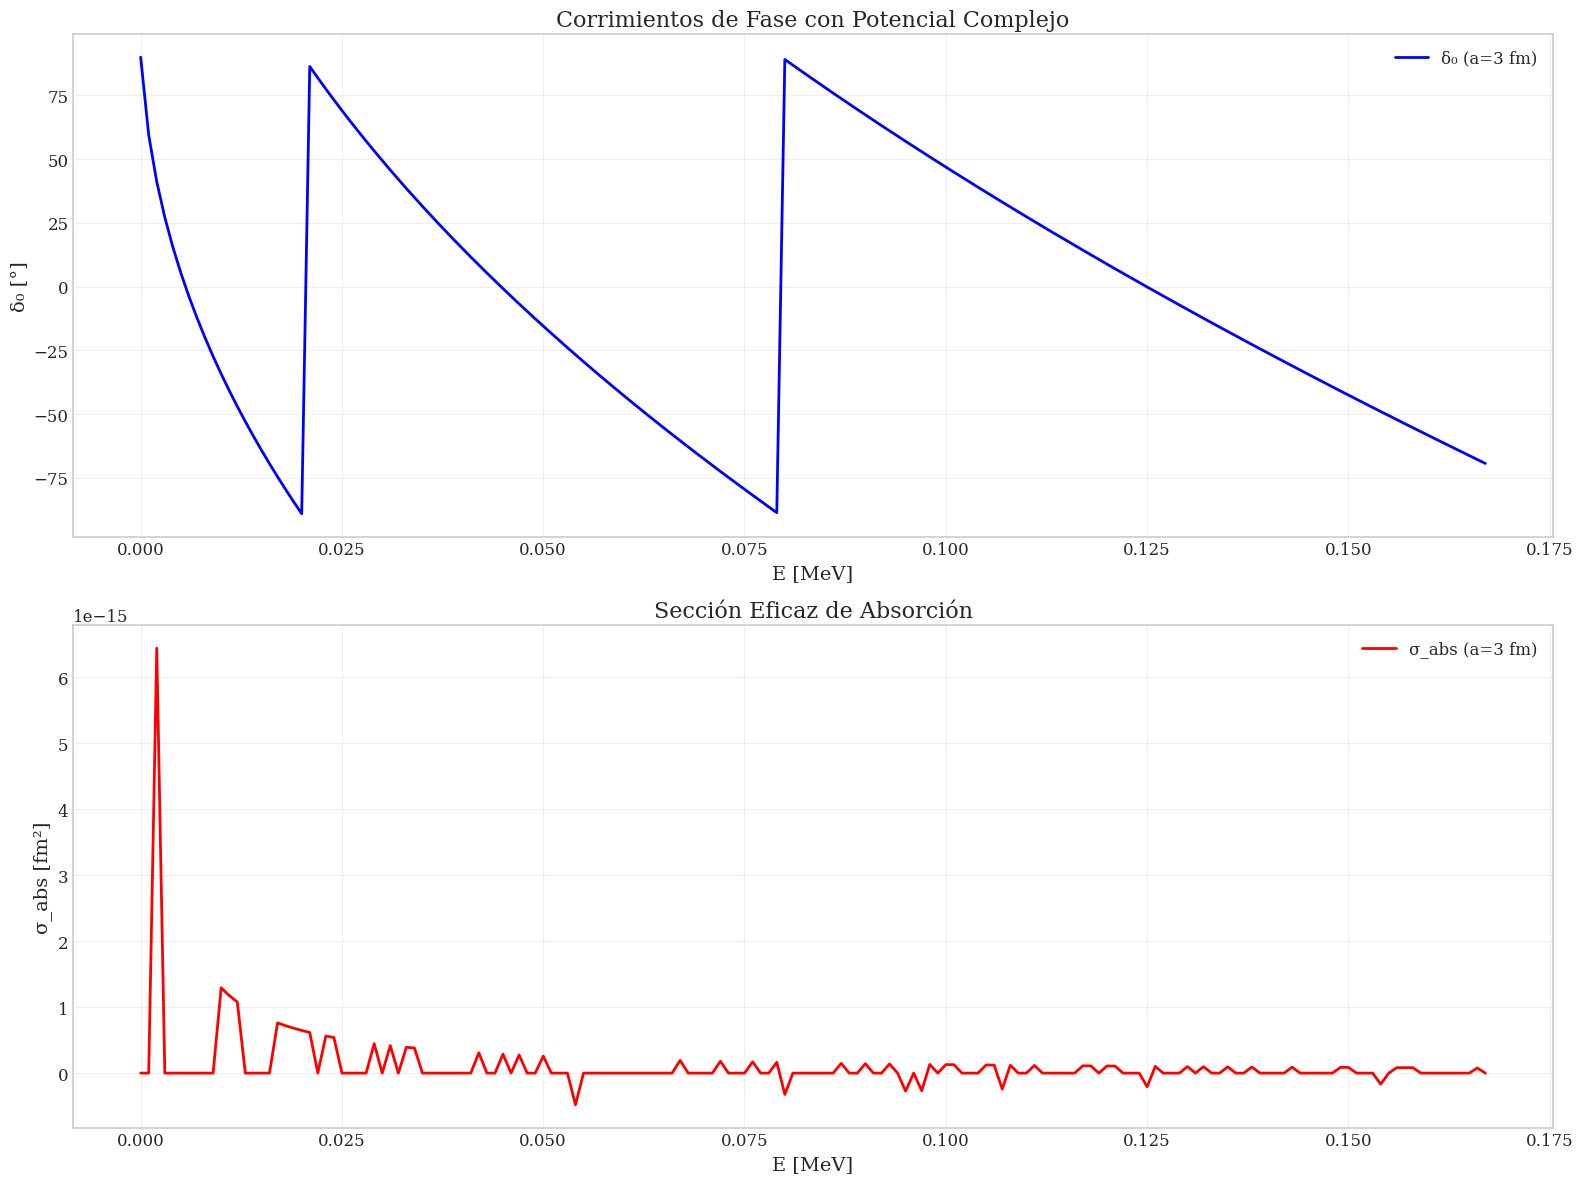


Potencial en r=0: (-30-0.04964j)
Potencial en r=R_N: (0.39828468854270077+0j)
Potencial en r=2*R_N: (0.19914234427135039+0j)
Potencial en r=5*R_N: (0.07965693770854015+0j)


In [14]:

import numpy as np
import matplotlib.pyplot as plt
import mpmath as mp
from scipy.special import legendre, roots_legendre
from scipy.integrate import quad
from scipy.special import eval_legendre
from scipy.linalg import pinv
# Parámetros del sistema
ZP = 1          # Carga del proyectil
ZT = 1          # Carga del blanco
Ap = 2          # Masa del proyectil (amu)
At = 3          # Masa del blanco (amu)
Vr = -30        # Parte real del potencial nuclear (MeV)
Vi = -0.04964   # Parte imaginaria del potencial nuclear (MeV)
r0 = 1.338      # Radio nuclear (fm)
e2 = 1.44       # Constante coulombiana (MeV·fm)

# Calcular parámetros derivados
mu = (Ap * At) / (Ap + At)  # Masa reducida
mua = mu * 931.494          # Masa reducida en MeV/c²
R_N = r0 * (Ap**(1/3) + At**(1/3))  # Radio nuclear



print(f"Radio nuclear R_N = {R_N:.3f} fm")
print(f"Masa reducida = {mu:.3f} amu = {mua:.1f} MeV/c²")

def Complex_Potential_Nuclear(r):
    """
    Potencial nuclear complejo
    """
    if r < R_N:
        return complex(Vr, Vi)  # Potencial complejo constante
    else:
        return complex(0.0, 0.0)  # No hay potencial nuclear fuera del núcleo

def Coulomb_Potential(r):
    """
    Potencial de Coulomb
    """
    if r >= R_N:
        return (ZP * ZT * e2) / r  # Potencial de Coulomb fuera del núcleo
    else:
        return 0.0  # Nada dentro del núcleo

def Total_Potential(r):
    """
    Potencial total: Nuclear complejo + Coulomb
    """
    V_nuclear = Complex_Potential_Nuclear(r)
    V_coulomb = Coulomb_Potential(r)
    return V_nuclear + V_coulomb

# Funciones de Lagrange-Legendre (asumiendo que ya están definidas)
def R_Lagrange_Legendre(j, x, N, n, a=3):
    r_j = roots_legendre(N)[0][j-1]
    x_j = (r_j+1)/2
    f_j = np.array([])

    for i in range(len(x)):
      if x[i] == a:
        f_j = np.append(f_j, ((-1)**(N-j))/np.sqrt(a*x_j*(1-x_j)))
      else:
        f_j = np.append(f_j, ((-1)**(N-j))*((x[i]/(a*x_j))**n)*np.sqrt(a*x_j*(1-x_j))*(legendre(N)(2*(x[i]/a)-1))/(x[i]-a*x_j))
    return f_j
    
def T_L_ij(x, i, j, N):
  T_ij = 0
  if i==j:
    T_ij = ((4*N**2+4*N+3)*x[i]*(1-x[i])-6*x[i]+1)/(3*(x[i]*(1-x[i]))**2)
  else:
    T_ij = ((-1)**(i+j))*( N**2+N+1 + (x[i]-2*x[i]*x[j]+x[j])/((x[i]-x[j])**2) - 1/(1-x[i]) - 1/(1-x[j]))/np.sqrt(x[i]*x[j]*(1-x[i])*(1-x[j]))
  #print(i, j, x[i], x[j])
  return T_ij

def T_L(mua, N, a):
  #hbar*c = 197 MeV fm

  hbar2mu = 20.736/mua

  #print('T_ij:')

  Constant = hbar2mu/(a**2)
  #print('Constant:', Constant)
  T_M = np.zeros((N, N))
  x = (roots_legendre(N)[0]+1)/2
  for i in range(N):
    for j in range(N):
      T_M[i, j] = T_L_ij(x, i, j, N)*Constant
      #print(T_M[i, j])

  #T_M*=Constant


  return T_M

def V(mu, N, R, RC, V0, l, a, mua = 0):
  V_M = np.zeros((N, N))
  r = a*(roots_legendre(N)[0]+1)/2
  for i in range(N):
    for j in range(N):
      V_M[i, j] = VL_efectivo(r[i], R, RC, V0, l, mu, mua, graph = False)*delta(i , j)
  return V_M

def Projection_Complex(mu, N, R, RC, l, a, mua):
    """
    Proyección modificada para potencial complejo
    
    Parámetros:
    mu: masa reducida
    N: número de puntos de base
    R: radio máximo del dominio
    RC: radio de corte del potencial
    l: momento angular
    a: parámetro de escala
    mua: parámetro mu*a
    
    Retorna:
    M: matriz hamiltoniana completa (cinética + potencial complejo)
    """
    # Matriz de energía cinética
    TM = T_L(mua, N, a)
    
    # Matriz de potencial complejo
    VM = np.zeros((N, N), dtype=complex)
    
    # Puntos y pesos de cuadratura Gauss-Legendre
    # Mapear del intervalo [-1,1] al dominio [0,R]
    x_gauss, w_gauss = np.polynomial.legendre.leggauss(N+10)  # Puntos extra para precisión
    
    # Transformar puntos de cuadratura al dominio físico [0,R]
    r_points = 0.5 * R * (x_gauss + 1)
    weights = 0.5 * R * w_gauss
    
    # Calcular las funciones de base de Lagrange-Legendre en los puntos de cuadratura
    def lagrange_basis(i, r):
        """Función de base de Lagrange-Legendre normalizada"""
        # Transformar r al dominio [-1,1]
        xi = 2*r/R - 1
        
        # Calcular la función de base usando polinomios de Legendre
        # Implementación simplificada - en práctica necesitarías las funciones exactas
        if abs(xi) <= 1:
            return eval_legendre(i, xi) * np.sqrt((2*i+1)/R)
        else:
            return 0.0
    
    # Calcular elementos de matriz del potencial complejo
    for i in range(N):
        for j in range(N):
            # Integración numérica: <phi_i | V_complex | phi_j>
            integrand = np.zeros(len(r_points), dtype=complex)
            
            for k, r in enumerate(r_points):
                if r > 0:  # Evitar singularidades en r=0
                    # Evaluar funciones de base
                    phi_i = lagrange_basis(i, r)
                    phi_j = lagrange_basis(j, r)
                    
                    # Evaluar potencial complejo
                    V_complex = Total_Potential(r)
                    
                    # Factor r^2 para coordenadas esféricas
                    integrand[k] = phi_i * V_complex * phi_j * r**2
            
            # Integración usando cuadratura
            VM[i,j] = np.sum(integrand * weights)
    
    # Matriz hamiltoniana total
    M = TM + VM
    return M


def R_matrix_Complex(E, mu, N, R, RC, l, a, mua):
    """
    Matriz R para potencial complejo
    """
    hbar = 197.326980
    hbar2mu = 20.736/mua

    H = Projection_Complex(mu, N, R, RC, l, a, mua)

    # Matriz compleja
    CM = H - E*np.eye(N, dtype=complex)
    
    # Inversión de matriz compleja
    C_Inv = pinv(CM, rtol=1e-15)

    index = np.arange(1, N+1, 1)
    f_index = R_Lagrange_Legendre(index, a, N=N, n=1, a=a[0])
    
    RM = np.linalg.multi_dot([f_index, C_Inv.T, f_index])
    RM *= hbar2mu/a[0]

    return RM

def Sommerfeld(Zp, ZT, mu, E):
    alpha = 0.0072973525693
    return alpha*Zp*ZT*np.sqrt(mu/(2*E))

def Dmin(Zp, ZT, E):
    return 1.44*Zp*ZT/(2*E)

def Haenkel_Coulomb(l, eta, rho, plus):
    F = np.vectorize(lambda x: mp.coulombf(l, eta, x))
    G = np.vectorize(lambda x: mp.coulombg(l, eta, x))

    if plus == True:
        H = G(rho) + 1j*F(rho)
    else:
        H = G(rho) - 1j*F(rho)
    return H

def diff_Haenkel_Coulomb(l, eta, rho, plus):
    F = np.vectorize(lambda x: mp.coulombf(l, eta, x))
    G = np.vectorize(lambda x: mp.coulombg(l, eta, x))

    dF = mp.diff(F, rho)
    dG = mp.diff(G, rho)

    if plus == True:
        dH = dG + 1j*dF
    else:
        dH = dG - 1j*dF

    return dH

def S_Matrix_Complex(R, l, eta, rho):
    """
    Matriz S para potencial complejo
    """
    H_minus = Haenkel_Coulomb(l, eta, rho, plus=False)
    H_plus = Haenkel_Coulomb(l, eta, rho, plus=True)

    dH_minus = diff_Haenkel_Coulomb(l, eta, rho, plus=False)
    dH_plus = diff_Haenkel_Coulomb(l, eta, rho, plus=True)

    # R es ahora complejo
    Sl = -(H_minus - rho*R*dH_minus)/(H_plus - rho*R*dH_plus)
    return Sl

def Phase_Shift_Complex(Sl):
    """
    Corrimiento de fase para matriz S compleja
    """
    PS = np.array([])
    for i in range(len(Sl)):
        Sl[i] = complex(np.real(Sl[i]), np.imag(Sl[i]))
        delta_j = np.arctan2(np.imag(Sl[i]), np.real(Sl[i]))/2
        PS = np.append(PS, delta_j)
    return PS

def Absorption_Cross_Section(k, Sl):
    """
    Sección eficaz de absorción
    σ(E) = (π/k²)(1 - |e^(2iδ₀)|²)
    """
    sigma = np.array([])
    for i in range(len(Sl)):
        # Extraer el corrimiento de fase complejo
        delta = np.arctan2(np.imag(Sl[i]), np.real(Sl[i]))/2
        
        # Calcular |e^(2iδ)|²
        exp_2i_delta = np.exp(2j * delta)
        abs_exp_2i_delta_sq = np.abs(exp_2i_delta)**2
        
        # Sección eficaz
        sigma_i = (np.pi / k[i]**2) * (1 - abs_exp_2i_delta_sq)
        sigma = np.append(sigma, sigma_i)
    
    return sigma

# Parámetros de cálculo
l = np.array([0])  # Momento angular
E = np.arange(0.00001, 0.168, 0.001)  # Energía en MeV
hbar = 197.326980

eta = Sommerfeld(ZP, ZT, mu, E)
N_val = 15
a_val = np.array([3])

hbar2mu = 20.736/mua
k = np.sqrt(E/hbar2mu)

# Cálculo principal
plt.figure(figsize=(16, 12))

Sl = np.array([])
delta_l = np.array([])

for a_i in range(len(a_val)):
    R_C = a_val[a_i]
    rho_vals = k * a_val[a_i]
    
    for i in range(len(E)):
        # Calcular matriz R compleja
        Rl = R_matrix_Complex(E[i], mu, N=N_val, R=2.7, RC=R_C, l=l[0], a=a_val, mua=mua)
        
        # Calcular matriz S compleja
        Sl_i = S_Matrix_Complex(Rl, l[0], eta[i], rho_vals[i])
        Sl = np.append(Sl, Sl_i)
    
    # Calcular corrimientos de fase
    delta_l = Phase_Shift_Complex(Sl)
    
    # Calcular sección eficaz de absorción
    sigma_abs = Absorption_Cross_Section(k, Sl)
    
    # Gráfica 1: Corrimientos de fase
    plt.subplot(2, 1, 1)
    plt.plot(E, 180*delta_l/np.pi, 'b-', linewidth=2, label=f'δ₀ (a={a_val[a_i]} fm)')
    plt.xlabel('E [MeV]')
    plt.ylabel('δ₀ [°]')
    plt.title('Corrimientos de Fase con Potencial Complejo')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Gráfica 2: Sección eficaz de absorción
    plt.subplot(2, 1, 2)
    plt.plot(E, sigma_abs, 'r-', linewidth=2, label=f'σ_abs (a={a_val[a_i]} fm)')
    plt.xlabel('E [MeV]')
    plt.ylabel('σ_abs [fm²]')
    plt.title('Sección Eficaz de Absorción')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Limpiar arrays para próxima iteración
    Sl = np.array([])
    delta_l = np.array([])

plt.tight_layout()
plt.savefig('Complex_Potential_Results.pdf', format='PDF', dpi=300)
plt.show()

# Imprimir algunos valores para verificación
print(f"\nPotencial en r=0: {Total_Potential(0)}")
print(f"Potencial en r=R_N: {Total_Potential(R_N)}")
print(f"Potencial en r=2*R_N: {Total_Potential(2*R_N)}")
print(f"Potencial en r=5*R_N: {Total_Potential(5*R_N)}")



